In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

#importing CSV
df = pd.read_csv('2019.csv')

#drop unneccessary columns
df.drop(['Rk', '2PM', '2PP', 'FantPt', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'PPR', 'Fmb', 'GS'], axis=1, inplace=True)

#fix name format
df['Player'] = df['Player'].apply(lambda x: x.split('*')[0]).apply(lambda x: x.split('\\')[0])
df.rename({
'TD': 'PassingTD',
'TD.1': 'RushingTD',
'TD.2': 'ReceivingTD',
'TD.3': 'TotalTD',
'Yds': 'PassingYDs',
'Yds.1': 'RushingYDs',
'Yds.2': 'ReceivingYDs',
'Att': 'PassingAtt',
'Att.1': 'RushingAtt'
}, axis=1, inplace=True)

#separate dataframes based off position
rb_df = df[df['FantPos'] == 'RB']
qb_df = df[df['FantPos'] == 'QB']
wr_df = df[df['FantPos'] == 'WR']
te_df = df[df['FantPos'] == 'TE']

df


,Player,Tm,FantPos,Age,G,Cmp,PassingAtt,PassingYDs,PassingTD,Int,...,RushingYDs,Y/A,RushingTD,Tgt,Rec,ReceivingYDs,Y/R,ReceivingTD,FL,TotalTD
0,Christian McCaffrey,CAR,RB,23,16,0,2,0,0,0,...,1387,4.83,15,142,116,1005,8.66,4,0,19
1,Lamar Jackson,BAL,QB,22,15,265,401,3127,36,6,...,1206,6.85,7,0,0,0,NaN,0,2,7
2,Derrick Henry,TEN,RB,25,15,0,0,0,0,0,...,1540,5.08,16,24,18,206,11.44,2,3,18
3,Aaron Jones,GNB,RB,25,16,0,0,0,0,0,...,1084,4.59,16,68,49,474,9.67,3,2,19
4,Ezekiel Elliott,DAL,RB,24,16,0,0,0,0,0,...,1357,4.51,12,71,54,420,7.78,2,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,Ray-Ray McCloud,CAR,NaN,23,6,0,0,0,0,0,...,0,NaN,0,0,0,0,NaN,0,1,0
599,Darrius Shepherd,GNB,WR,24,6,0,0,0,0,0,...,0,NaN,0,2,1,1,1.00,0,1,0
600,Jarrett Stidham,NWE,QB,23,3,2,4,14,0,1,...,-2,-1.00,0,0,0,0,NaN,0,0,0
601,Michael Walker,JAX,WR,23,7,0,0,0,0,0,...,0,NaN,0,3,2,15,7.50,0,2,0


In [3]:
#assigning columns to dataframes
rushing_columns = ['RushingAtt','RushingYDs','Y/A','RushingTD']
receiving_columns = ['Tgt','Rec','ReceivingYDs', 'Y/R', 'ReceivingTD']
passing_columns = ['PassingAtt', 'PassingYDs', 'PassingTD','Int']
def transform_columns(df, new_column_list):
    df =df[['Player','Tm','Age','G']+ new_column_list + ['FL']]
    return df

In [4]:
rb_df = transform_columns(rb_df, rushing_columns+receiving_columns)
wr_df = transform_columns(wr_df, rushing_columns+receiving_columns)
te_df = transform_columns(te_df, rushing_columns+receiving_columns)
qb_df = transform_columns(qb_df, rushing_columns+receiving_columns)

rb_df.head()

,Player,Tm,Age,G,RushingAtt,RushingYDs,Y/A,RushingTD,Tgt,Rec,ReceivingYDs,Y/R,ReceivingTD,FL
0,Christian McCaffrey,CAR,23,16,287,1387,4.83,15,142,116,1005,8.66,4,0
2,Derrick Henry,TEN,25,15,303,1540,5.08,16,24,18,206,11.44,2,3
3,Aaron Jones,GNB,25,16,236,1084,4.59,16,68,49,474,9.67,3,2
4,Ezekiel Elliott,DAL,24,16,301,1357,4.51,12,71,54,420,7.78,2,2
5,Dalvin Cook,MIN,24,14,250,1135,4.54,13,63,53,519,9.79,0,2


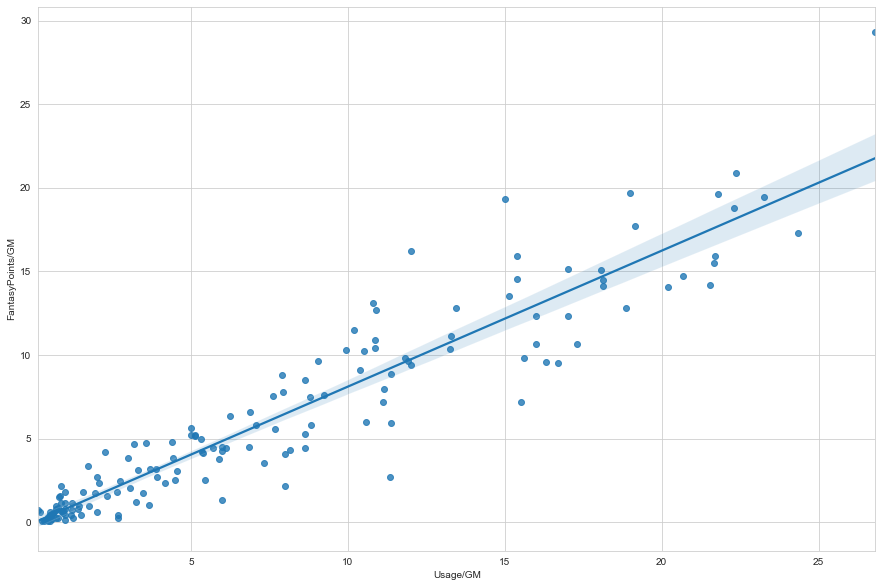

In [5]:
#Did targets + rushing TDs correlate to fantasy ppg for RBs?

#Creates new column to calculate fantasy points scored (PPR)
rb_df['FantasyPoints'] = rb_df['RushingYDs']*0.1 + rb_df['RushingTD']*6 + rb_df['Rec'] + rb_df['ReceivingYDs']*0.1 + rb_df ['ReceivingTD']*6 - rb_df['FL']*2

#Create new column for Fantasy points per game.
rb_df['FantasyPoints/GM'] = rb_df['FantasyPoints']/rb_df['G']
rb_df['FantasyPoints/GM'] = rb_df['FantasyPoints/GM'].apply(lambda x: round(x, 2))

#Create new column for usage per game. Usage is defined as # of targets + carries
rb_df['Usage/GM'] = (rb_df['RushingAtt'] + rb_df['Tgt'])/rb_df['G']

#round each row value to two decimal places
rb_df['Usage/GM'] = rb_df['Usage/GM'].apply(lambda x: round(x, 2))

#just for styling. We imported seaborn earlier as sns.
sns.set_style('whitegrid')

#create a canvas with matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

#basic regression scatter plot with trendline
plot = sns.regplot(
x=rb_df['Usage/GM'],
y=rb_df['FantasyPoints/GM'],
scatter=True,)

In [ ]:
#So we can see that Usage/GM is correlated

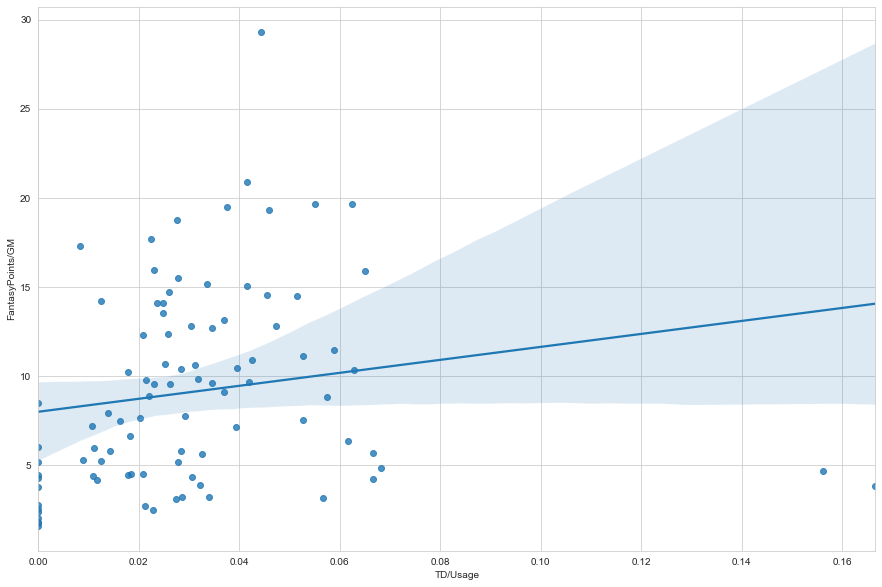

In [6]:
#How does efficiency correlate to fantasy football performance?
rb_df['TD/Usage'] = (rb_df['RushingTD']+ rb_df['ReceivingTD'])/(rb_df['RushingAtt'] + rb_df['Tgt'])
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

#Make sure there is an adequete sample size
rb_df = rb_df[rb_df['RushingAtt'] > 20]
plot = sns.regplot(
x=rb_df['TD/Usage'],
y=rb_df['FantasyPoints/GM'],
scatter=True)

In [ ]:
#Here we can see efficiency is not as strongly correlated as usage